<a href="https://colab.research.google.com/github/adam-s/stocks_1/blob/main/stocks_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet python-dotenv
%load_ext dotenv
import sys
# Check if this is colab
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount("/content/gdrive", False)
  %dotenv /content/gdrive/MyDrive/stocks/.env
else:
  %dotenv .env

Mounted at /content/gdrive


In [ ]:
!pip install --quiet yfinance
!pip install --quiet --upgrade ta
!pip install --quiet s3fs

     |████████████████████████████████| 6.3MB 4.5MB/s 
     |████████████████████████████████| 122kB 4.1MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 7.7MB 7.5MB/s 
     |████████████████████████████████| 1.3MB 24.8MB/s 
     |████████████████████████████████| 143kB 61.0MB/s 
     |████████████████████████████████| 296kB 61.3MB/s 
     |████████████████████████████████| 143kB 58.8MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
import os
import io
import numpy as np
import pandas as pd
import random
import time
import requests
from datetime import datetime, timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing, cluster, covariance, manifold
from sklearn.model_selection import train_test_split
from collections import deque
import matplotlib.pyplot as plt
import yfinance as yf
import ta
import s3fs

from ta.momentum import StochRSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volume import ChaikinMoneyFlowIndicator, ForceIndexIndicator, MFIIndicator


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
# np.random.seed(314)
# tf.random.set_seed(314)
# random.seed(314)

In [ ]:
# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 15
# test ratio size, 0.30 is 30%
TEST_SIZE = 0.30
# Shuffle the dataset
SHUFFLE = True

### model parameters
N_LAYERS = 2
# 256 LSTM neurons
UNITS = 128
# 30% dropout
DROPOUT = 0.30
# whether to use bidirectional RNNs
BIDIRECTIONAL = True

### training parameters
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400

DATE_NOW = time.strftime("%Y-%m-%d")

INDICES = ['SPY','VXX','QQQ']

# File directories
BUCKET = 's3://robin-thee-hood-stocks'
PREDICTIONS_DIR = 'predictions'
DIRECTORY = f'{BUCKET}/{DATE_NOW}' # Probably don't need this


In [ ]:
class HistoricalPrices:
  def __init__(self, SP500_companies=None, stocks=None, clusters=None, period='2y'):
    self.period = period

    # self._insure_directories()
    update_SP500_companies = False
    if isinstance(SP500_companies, pd.DataFrame):
      self.SP500_companies = SP500_companies
    else:
      self.SP500_companies = self.fetch_SP500_companies()
      update_SP500_companies = True
    
    # Allow passing in the data frame for development so it doesn't take forever
    # to load all the stocks
    update_stocks = False
    if isinstance(stocks, pd.DataFrame):
      self.stocks = stocks
    else:
      self.stocks = self._fetch_stocks()
      update_stocks = True

    update_clusters = False
    if isinstance(clusters, list):
      self.clusters = clusters
    else:
      self.clusters = self.process_clusters()
      update_clusters = True


    # Find the last value of the date index to set the time all the data and
    # predictions belong to
    self.date = self.stocks.last_valid_index()
    self.date = self.date.strftime("%Y-%m-%d")

    # Save files if updated
    if update_SP500_companies:
      self.save_SP500_companies_to_file()
    if update_stocks:
      self.save_stocks_to_file()
    if update_clusters:
      self.save_clusters_to_file()
      

  # def _insure_directories(self):
  #   # Insure the directories exist
  #   try:
  #     os.makedirs(f'{BUCKET}/{DATE_NOW}/{PREDICTIONS_DIR}')
  #   except:
  #     pass

  @staticmethod
  def fetch_SP500_companies():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data = pd.read_html(wiki_page)
    return pd.DataFrame(sp_data[0])

  def save_SP500_companies_to_file(self):
    self.SP500_companies.to_pickle(f'{BUCKET}/{self.date}/SP500_companies.pickle')

  def _fetch_stocks(self):
    # Add SPY for later comparisons
    spy = pd.Series(INDICES)
    symbols = self.SP500_companies.loc[:, 'Symbol'].copy().append(spy, ignore_index=True)
    return yf.download(
        ','.join(symbols).replace('.','-'),
        period=self.period,
        threads=True
      )
  
  def save_stocks_to_file(self):
    self.stocks.to_pickle(f'{BUCKET}/{self.date}/historical_prices.pickle')

  def process_clusters(self):
    scalar = preprocessing.MinMaxScaler()
    # Only get ~3 months, or 60 periods
    variation = self.stocks.iloc[-60:]['Adj Close'].copy()
    variation = variation.pct_change()
    variation = variation.fillna(0.0)
    variation[variation.columns] = scalar.fit_transform(variation[variation.columns])
    edge_model = covariance.GraphicalLassoCV(verbose=True, n_jobs=-1, n_refinements=3, tol=0.001)
    X = variation.copy()
    X /= X.std(axis=0)
    edge_model.fit(X, )
    _, labels = cluster.affinity_propagation(edge_model.covariance_)
    n_labels = labels.max()
    names=[]
    for stock in variation.columns.tolist():
        names.append(stock)
    names = np.array(names)
    clusters = []
    for i in range(n_labels + 1):
      clusters.append(names[labels == i])
    return clusters

  def save_clusters_to_file(self):
    pd.to_pickle(self.clusters, f'{BUCKET}/{self.date}/clusters.pickle')

  def get_cluster(self, symbol):
    for cluster_list in self.get_clusters_chunked():
      if symbol in cluster_list:
        return cluster_list

  def get_clusters_chunked(self):
    # chuck the clusters
    cluster_chunked = []
    for clust in self.clusters:
      # Remove the SPY before chunking
      for symbol in INDICES:
        if symbol in clust:
          index = np.argwhere(clust==symbol)
          clust = np.delete(clust, index)
      for item in [clust[i:i + 4] for i in range(0, len(clust), 1)]:
        cluster_chunked.append(item)
    return cluster_chunked;

# def get_historical_prices():
#   stocks = None
#   SP500_companies = None
#   clusters = None
#   try:
#     stocks = pd.read_pickle(f'{BUCKET}/2021-07-13/historical_prices.pickle')
#     SP500_companies = pd.read_pickle(f'{BUCKET}/2021-07-13/SP500_companies.pickle')
#     clusters = pd.read_pickle(f'{BUCKET}/2021-07-02/clusters.pickle')
#   except:
#     pass

#   return HistoricalPrices(stocks=stocks, SP500_companies=SP500_companies, clusters=clusters)

# historical_prices = get_historical_prices()

# for symbol in 'AFL,AIG,AIZ,ALL,AMP,AXP,BAC'.split(','):
#   stock_cluster = historical_prices.get_cluster(symbol)
#   print(stock_cluster)

# tickers = []
# for i in historical_prices.clusters:
#   tickers.append(i[0])
#   print("'" + "','".join(i) + "'")
# print(",".join(tickers))


In [ ]:
# df = historical_prices.stocks.loc[(slice(None)), (slice(None), 'PYPL')].copy()
# df.columns = [col[0].lower().replace(' ', '_') for col in df.columns]
# indicators_df = ta.add_all_ta_features(df.copy(), 'open', 'high', 'low', 'close', 'volume', fillna=True)
# print(indicators_df)

In [ ]:
class Data():
  def __init__(self, symbol, historical_prices):
    # string of the symobol
    self.symbol = symbol
    self.historical_prices = historical_prices
    # One of these dataframes gets mutated
    self.df, self.original_df = self._set_df()
    self.feature_columns = self._set_feature_columns()
    self.column_scaler = self._set_scale()
    self.df['future'] = self._set_future()
    self.last_sequence, self.sequence_data = self._set_last_sequence()
    self.X_train, self.X_test, self.y_train, self.y_test, self.test_df = self._split_data()

  def _get_df(self, symbol):
    df = self.historical_prices.stocks.loc[(slice(None)), (slice(None), symbol)].copy()
    df.columns = [col[0].lower().replace(' ', '_') for col in df.columns]
    return df

  def _set_df(self, with_comps=True):
    # Set the data frame with the only columns needed from historical_prices
    df = self._get_df(self.symbol)

    if with_comps:
      cluster = self.historical_prices.get_cluster(self.symbol)
      cluster = pd.Series(cluster)
      cluster = cluster.append(pd.Series(INDICES))
      # cluster = cluster[cluster != self.symbol]
      for symbol in cluster:
        indicator_df = self._get_df(symbol)

        # Stoch RSI (StochRSI)
        indicator_srsi = StochRSIIndicator(
            close=indicator_df['adj_close'], window=14, smooth1=3, smooth2=3, fillna=True
        )
        indicator_df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
        indicator_df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
        indicator_df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()

            # Bollinger Bands
        indicator_bb = BollingerBands(
            close=indicator_df['adj_close'], window=20, window_dev=2, fillna=True
        )
        indicator_df["volatility_bbm"] = indicator_bb.bollinger_mavg()
        indicator_df["volatility_bbh"] = indicator_bb.bollinger_hband()
        indicator_df["volatility_bbl"] = indicator_bb.bollinger_lband()
        indicator_df["volatility_bbw"] = indicator_bb.bollinger_wband()
        indicator_df["volatility_bbp"] = indicator_bb.bollinger_pband()
        indicator_df["volatility_bbhi"] = indicator_bb.bollinger_hband_indicator()
        indicator_df["volatility_bbli"] = indicator_bb.bollinger_lband_indicator()

        # Chaikin Money Flow
        indicator_df["volume_cmf"] = ChaikinMoneyFlowIndicator(
            high=indicator_df['high'],
            low=indicator_df['low'],
            close=indicator_df['adj_close'],
            volume=indicator_df['volume'],
            fillna=True,
        ).chaikin_money_flow()

        # Force Index
        indicator_df["volume_fi"] = ForceIndexIndicator(
            close=indicator_df['adj_close'], volume=indicator_df['volume'], window=13, fillna=True
        ).force_index()

        # Money Flow Indicator
        indicator_df["volume_mfi"] = MFIIndicator(
            high=indicator_df['high'],
            low=indicator_df['low'],
            close=indicator_df['adj_close'],
            volume=indicator_df['volume'],
            window=14,
            fillna=True,
        ).money_flow_index()


        # MACD
        indicator_macd = MACD(
            close=indicator_df['adj_close'], window_slow=26, window_fast=12, window_sign=9, fillna=True
        )
        indicator_df["trend_macd"] = indicator_macd.macd()
        indicator_df["trend_macd_signal"] = indicator_macd.macd_signal()
        indicator_df["trend_macd_diff"] = indicator_macd.macd_diff()

        columns = ['momentum_stoch_rsi',
                  'momentum_stoch_rsi_k',
                  'momentum_stoch_rsi_d',
                  'volatility_bbm',
                  'volatility_bbh',
                  'volatility_bbl',
                  'volatility_bbw',
                  'volatility_bbp',
                  'volatility_bbhi',
                  'volatility_bbli',
                  'volume_cmf',
                  'volume_mfi',
                  'volume_fi',
                  'trend_macd',
                  'trend_macd_signal',
                  'trend_macd_diff']
        indicator_df = indicator_df[columns]
        indicator_df.columns = f"{symbol}_" + indicator_df.columns
        df = df.assign(**indicator_df)

    # def comps(column):
    #   # get the columns for comps and spy
    #   cluster = self.historical_prices.get_cluster(self.symbol)
    #   cluster = pd.Series(cluster)
    #   cluster = cluster.append(pd.Series(INDICES))
    #   cluster = cluster[cluster != self.symbol]
    #   price_df = self.historical_prices.stocks.loc[slice(None), (column, cluster)]
    #   price_df = price_df.droplevel(0, axis=1)
    #   price_df.columns = price_df.columns + "_" + column.lower().replace(' ', '_')
    #   return df.merge(price_df, how="outer", right_index=True, left_index=True)

    # if with_comps:
    #   df = comps('Adj Close')
    #   df = comps('Volume')
    # Add date column at the end

    df['date'] = df.index

    return df, df.copy()

  def _set_feature_columns(self):
    feature_columns = self.df.columns.to_series()
    return feature_columns.drop(["date", "close", "high", "close"])

  def _set_scale(self):
    # scale the data (prices) from 0 to 1
    column_scaler = {}
    for column in self.feature_columns:
      scalar = preprocessing.MinMaxScaler()
      self.df[column] = scalar.fit_transform(np.expand_dims(self.df[column].values, axis=1))
      column_scaler[column] = scalar
    return column_scaler

  def _set_future(self):
    # add the target column (label) by shifting by `lookup_step`
    return self.df['adj_close'].shift(-LOOKUP_STEP)

  def _set_last_sequence(self):
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(self.df[self.feature_columns].tail(LOOKUP_STEP))
    # drop NaNs
    self.df.dropna(inplace=True)
    
    sequence_data = []
    sequences = deque(maxlen=N_STEPS)

    # index = self.feature_columns.append(pd.Index(["date"]))
    for entry, target in zip(self.df[self.feature_columns.append(pd.Series(["date"]))].values, self.df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
        sequence_data.append([np.array(sequences), target])

    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict future stock prices that are not available in the dataset
    last_sequence = list([s[:len(self.feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)

    return last_sequence, sequence_data
  
  def _split_data(self):
    # Construct the X's and y's
    X, y = [], []
    for seq, target in self.sequence_data:
      X.append(seq)
      y.append(target)

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # split the dataset randomly
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=SHUFFLE)

    # get the list of test set dates
    dates = X_test[:, -1, -1]
    
    # retrieve test features from the original dataframe
    test_df = self.original_df.loc[dates]
    # remove duplicated dates in the testing dataframe
    test_df = test_df[~test_df.index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    X_train = X_train[:, :, :len(self.feature_columns)].astype(np.float32)
    X_test = X_test[:, :, :len(self.feature_columns)].astype(np.float32)
    return X_train, X_test, y_train, y_test, test_df

# data = Data('PYPL', historical_prices)

In [ ]:
class Model():
  def __init__(self, data, model_date=None):
    tf.keras.backend.clear_session()
    self._insure_directories()
    self.model_name = data.symbol
    self.data = data
    historical_prices_date = self.data.historical_prices.date
    # All passing model fit date to use previous models saved from earlier
    if model_date:
      historical_prices_date = model_date
    self.s3_path = f"{BUCKET}/{historical_prices_date}/results/{self.model_name}.h5"
    self.model_path = os.path.join(f"results", self.model_name) + ".h5"
    self.s3 = s3fs.S3FileSystem(anon=False)
    self.load_model_remote()
    self.model = self._build()
    if not model_date:
      # Saves the best weight set to file
      self.history = self._fit()
    # Need to load the best weight set from file into memory
    self._set_weights()
    if not model_date:
      self.save_model_remote()
    self.remove_model_local()

  @staticmethod
  def _insure_directories():
    # create these folders if they does not exist
    if not os.path.isdir(f"results"):
        os.mkdir(f"results")

  def _build(self):
    n_features = len(self.data.feature_columns)
    batch_input_shape = (None, N_STEPS, n_features)
    model = Sequential()
    for i in range(N_LAYERS):
      if i == 0:
        # First layer
        if BIDIRECTIONAL:
          model.add(Bidirectional(LSTM(UNITS, return_sequences=True), batch_input_shape=batch_input_shape))
        else:
          model.add(LSTM(UNITS, return_sequences=True, batch_input_shape=batch_input_shape))
      elif i == N_LAYERS - 1:
        # Last layer
        if BIDIRECTIONAL:
          model.add(Bidirectional(LSTM(UNITS, return_sequences=False)))
        else:
          model.add(LSTM(UNITS, return_sequences=False))
      else:
        # Hidden layers
        if BIDIRECTIONAL:
          model.add(Bidirectional(LSTM(UNITS, return_sequences=True)))
        else:
          model.add(LSTM(UNITS, return_sequences=True))
      # Add dropout after each layer
      model.add(Dropout(DROPOUT))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=LOSS, metrics=["mean_absolute_error"], optimizer=OPTIMIZER)
    return model

  def _fit(self):
    # some tensorflow callbacks
    checkpointer = ModelCheckpoint(os.path.join(f"results", self.model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=0)
    return self.model.fit(self.data.X_train, self.data.y_train,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=(self.data.X_test, self.data.y_test),
                        # callbacks=[checkpointer, tensorboard],
                        callbacks=[checkpointer],
                        verbose=0)
  def _set_weights(self):
    # load optimal model weights from results folder
    model_path = os.path.join(f"results", self.model_name) + ".h5"
    self.model.load_weights(model_path)

  def load_model_remote(self):
    if self.s3.exists(self.s3_path):
      self.s3.get(self.s3_path, self.model_path)

  def save_model_remote(self):
    model_path = os.path.join(f"results", self.model_name) + ".h5"
    self.s3.put(self.model_path, self.s3_path)

  def remove_model_local(self):
    if os.path.isfile(self.model_path):
      os.remove(self.model_path)
  

# model = Model(data, run_fit=True)

In [ ]:
class Result():
  def __init__(self, data, model):
    self.data = data
    self.model = model
    self.model_name = data.symbol
    self.s3 = s3fs.S3FileSystem(anon=False)
    self.result_df = self.build_result_df()
    self.future_df = self.predictions()

  def build_result_df(self):
    # if predicted future price is higher than the current, 
    # then calculate the true future price minus the current price, to get the buy profit
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    # if the predicted future price is lower than the current price,
    # then subtract the true future price from the current price
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0

    X_test = self.data.X_test
    y_test = self.data.y_test
    # perform prediction and get prices
    
    y_pred = self.model.model.predict(X_test)

    y_test = np.squeeze(self.data.column_scaler["adj_close"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(self.data.column_scaler["adj_close"].inverse_transform(y_pred))

    result_df = self.data.test_df.copy()

    # add predicted future prices to the dataframe
    result_df[f"adj_close_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    result_df[f"true_adj_close_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    result_df.sort_index(inplace=True)
    # add the buy profit column
    result_df["buy_profit"] = list(map(buy_profit, 
                                    result_df["adj_close"], 
                                    result_df[f"adj_close_{LOOKUP_STEP}"], 
                                    result_df[f"true_adj_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    # add the sell profit column
    result_df["sell_profit"] = list(map(sell_profit, 
                                    result_df["adj_close"], 
                                    result_df[f"adj_close_{LOOKUP_STEP}"], 
                                    result_df[f"true_adj_close_{LOOKUP_STEP}"])
                                    # since we don't have profit for last sequence, add 0's
                                    )
    return result_df

  def plot_graph(self):
    plt.figure(figsize=(8,4))
    plt.plot(self.future_df[f'adj_close'], c='b')
    plt.plot(self.future_df[f'adj_close_{LOOKUP_STEP}'][np.isfinite(self.future_df[f'adj_close_{LOOKUP_STEP}'])], c='r')
    plt.plot(self.future_df['forecast_close'], c='g', linewidth=3)
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price", "Forecast Price"])
    plt.title(f"{self.data.symbol} - {self.data.historical_prices.date}")
    plt.tight_layout()
    # saving matplotlib image to S3 bucket from EC2 instance
    # https://stackoverflow.com/a/66010347/494664
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)
    with self.s3.open(f"{BUCKET}/{self.data.historical_prices.date}/figures/{self.model_name}.png", 'wb') as f:
      f.write(img_data.getbuffer())
    plt.show()

  def predictions(self):
    # original_df DataFrame has all the dates with the correct adj_close for that day
    original_df = self.data.original_df.copy()
    original_df = original_df.loc[:, ["adj_close"]]

    # result_df DataFrame is the predicted values, however, on the period in
    #   the future prediction happend (15 periods ahead)
    result_df = self.result_df
    result_df = result_df.loc[:, [f"adj_close_{LOOKUP_STEP}"]]

    # merge the values on the date. Since original_df only have trading
    #   business day dates shift the predictions 15 periods in the future
    merged_df = original_df.merge(result_df, left_on="Date", right_on="Date", how="outer")
    merged_df[f'adj_close_{LOOKUP_STEP}'] = merged_df[f'adj_close_{LOOKUP_STEP}'].shift(LOOKUP_STEP)

    # Create a DataFrame with all the feature columns
    feature_columns = self.data.feature_columns
    too_future = pd.DataFrame(columns=feature_columns)
    future_df = self.data.original_df.dropna()
    for column in feature_columns:
        values = future_df[column].values
        too_future[column] = self.data.column_scaler[column].fit_transform(np.expand_dims(values, axis=1)).flatten()

    # Create an index of dates starting now looking forward 15 periods excluding holidays and weekends
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    date_index_future = pd.DatetimeIndex(pd.date_range(start=DATE_NOW, periods=LOOKUP_STEP, freq=us_bd), name='Date')

    # Create windows for predicting the next N_STEPS periods
    periods = len(date_index_future)
    windows = []
    for i in range(0, periods):
      future_window = too_future[-(N_STEPS + i): (len(too_future) if i < 1 else -i)]
      way_too_future = np.array(future_window).astype(np.float32)
      windows.append(way_too_future)
  
    windows = np.array(windows)
    predictions = self.model.model.predict(windows)
    predictions = np.squeeze(self.data.column_scaler["adj_close"].inverse_transform(predictions))
    predictions = predictions[::-1]

    # Create a DataFrame with the future date index and predictions
    future_df = pd.DataFrame(predictions, columns=['forecast_close'], index=date_index_future)
    merged_df = merged_df.merge(future_df, on='Date', how='outer')

    #save to disk
    merged_df.to_csv(f"{BUCKET}/{self.data.historical_prices.date}/predictions/{self.model_name}.csv")

    return merged_df

  def stats(self):
    mean_absolute_error, loss = self.mean_absolute_error()
    future_price = self.single_prediction
    # we calculate the accuracy by counting the number of positive profits
    accuracy_score = (len(self.result_df[self.result_df['sell_profit'] > 0]) + len(self.result_df[self.result_df['buy_profit'] > 0])) / len(self.result_df)
    # calculating total buy & sell profit
    total_buy_profit  = self.result_df["buy_profit"].sum()
    total_sell_profit = self.result_df["sell_profit"].sum()
    # total profit by adding sell & buy together
    total_profit = total_buy_profit + total_sell_profit
    # dividing total profit by number of testing samples (number of trades)
    profit_per_trade = total_profit / len(self.result_df)
                                          
    # prin~ting metrics
    print(f"Future price after {LOOKUP_STEP} days is ${future_price:.2f}")
    print(f"{LOSS} loss:", loss)
    print("Mean Absolute Error:", mean_absolute_error)
    print("Accuracy score:", accuracy_score)
    # print("Total buy profit:", total_buy_profit)
    # print("Total sell profit:", total_sell_profit)
    # print("Total profit:", total_profit)
    # print("Profit per trade:", profit_per_trade)
    # Return a DataFrame with result stats

  def mean_absolute_error(self):
    loss, mae = self.model.model.evaluate(self.data.X_test, self.data.y_test, verbose=0)
    return self.data.column_scaler["adj_close"].inverse_transform([[mae]])[0][0], loss

  @property
  def single_prediction(self):
    # retrieve the last sequence from data
    last_sequence = self.data.last_sequence[-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = self.model.model.predict(last_sequence)
    # get the price (by inverting the scaling)
    return self.data.column_scaler["adj_close"].inverse_transform(prediction)[0][0]

# result = Result(data, model)
# result.plot_graph()
# print(result.stats())

In [ ]:
# With volume
# Future price after 15 days is $244.52
# huber_loss loss: 0.0002689722168724984
# Mean Absolute Error: 88.91641381398969
# Accuracy score: 0.9545454545454546
# Total buy profit: 1171.7850646972654
# Total sell profit: 570.2599716186523
# Total profit: 1742.0450363159177
# Profit per trade: 15.836773057417433

In [ ]:
class Processor():
  def __init__(self):
    # self._insure_directories()
    self.historical_prices = self._get_historical_prices()

  # def _insure_directories(self):
  #   # Insure the directories exist
  #   try:
  #     os.makedirs(f's3://{BUCKET}/{DATE_NOW}/{PREDICTIONS_DIR}')
  #   except:
  #     pass

  def _get_historical_prices(self):
    stocks = None
    SP500_companies = None
    clusters = None
    try:
      stocks = pd.read_pickle(f'{BUCKET}/2021-07-09/historical_prices.pickle')
      SP500_companies = pd.read_pickle(f'{BUCKET}/2021-07-09/SP500_companies.pickle')
      clusters = pd.read_pickle(f'{BUCKET}/2021-07-08/clusters.pickle')
    except Exception as e:
      print(f"Error: {e}")
      pass
    # return HistoricalPrices(stocks=None, SP500_companies=SP500_companies, clusters=clusters)
    return HistoricalPrices(stocks=None, SP500_companies=None, clusters=None)

  def run(self):
    # Loop through stocks
    companies = self.historical_prices.SP500_companies.loc[:, "Symbol"]
    final_df = pd.DataFrame(index=pd.DatetimeIndex([], name='Date'))
    # for index, symbol in companies.iteritems():
    for index, symbol in pd.Series(['DD', 'SYF']).iteritems():
    # for index, symbol in pd.Series(['DD', 'DISCA', 'OXY', 'TSN', 'VRTX', 'GPS', 'SYF']).iteritems():
      try:
        print('*' * 60)
        print(f'Running: {symbol} {index} out of {companies.size}')

        data = Data(symbol.replace(".", "-"), self.historical_prices)
        model = Model(data)
        result = Result(data, model)
        result.plot_graph()
        # Grab the future results
        future_df = result.future_df.iloc[-LOOKUP_STEP:,2:]
        future_df = future_df.rename(columns={'forecast_close': symbol})
        # Merge the future results into the final_df on date
        final_df = final_df.merge(future_df, on='Date', how='outer')
        # This method prints stats returns void
        result.stats()
        print('\n')
      except ValueError as e:
        print(f'Error: {symbol} : {e}')
        pass
    # Save the future_df to file
    # final_df.to_csv(f"{BUCKET}/{self.historical_prices.date}/predictions_{self.historical_prices.date}.csv")


[*********************100%***********************]  508 of 508 completed


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[GraphicalLassoCV] Done refinement  1 out of 3:   9s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[GraphicalLassoCV] Done refinement  2 out of 3:  24s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.3s finished


[GraphicalLassoCV] Done refinement  3 out of 3:  51s
************************************************************
Running: DD 0 out of 505


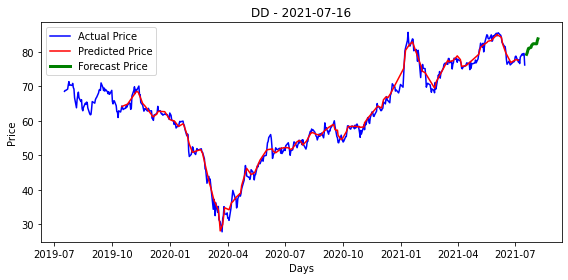

Future price after 15 days is $83.56
huber_loss loss: 0.0002205967903137207
Mean Absolute Error: 28.725648375542338
Accuracy score: 0.9097744360902256


************************************************************
Running: SYF 1 out of 505


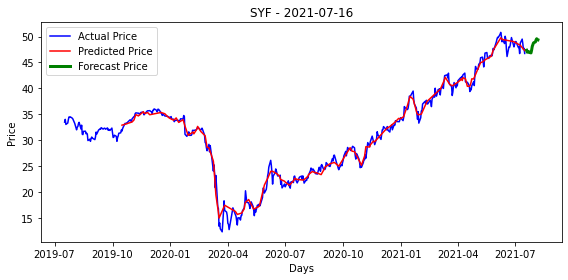

Future price after 15 days is $48.79
huber_loss loss: 0.0002656028082128614
Mean Absolute Error: 12.944802612238878
Accuracy score: 0.924812030075188




In [ ]:
processor = Processor()
processor.run()

In [ ]:
# df = pd.read_pickle('/content/stock_data/2021-07-04/2021-07-04_predictions.pickle')
# df

In [ ]:
# df.pct_change(periods=1) * 100

In [ ]:
# df.pct_change(periods=8)*100

In [ ]:
# !zip -r stock_data.zip stock_data


In [ ]:
# from google.colab import files
# files.download("/content/stock_data.zip")